In [1]:
import pandas as pd
import numpy as np
import sklearn.tree as tree
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# 1° Load data

In [2]:
data = pd.read_csv("Data/miniloan-decisions-100K.csv")

In [3]:
data

,name,creditScore,income,loanAmount,monthDuration,rate,approval,yearlyReimbursement
0,John Doe,736,113243,783440,162,0.030005,false,70648
1,John Doe,527,224186,1787385,183,0.054819,false,173197
2,John Doe,460,39954,1733494,75,0.055183,false,328563
3,John Doe,751,219998,1350004,72,0.043400,false,255970
4,John Doe,684,72470,1210944,160,0.037772,false,115742
...,...,...,...,...,...,...,...,...
99995,John Doe,366,83851,1718571,168,0.053737,false,174928
99996,John Doe,395,184259,1599473,90,0.040564,false,247703
99997,John Doe,674,242620,1099790,260,0.040825,false,76557
99998,John Doe,420,180957,1645870,203,0.049558,false,143897


# 2° Create the thresholds

In [4]:
thresholds = np.arange(0.1,1,0.1)
thresholds_str = ["-"+(str(int(i*100))) for i in thresholds]

In [5]:
def fromColumnToColumnPercent(name, percents):
    res = []
    for i in percents:
        res.extend([name[0]+i]*(len(percents)**(len(name)-1))) 
    return res

In [6]:
data.columns

Index(['name', 'creditScore', 'income', 'loanAmount', 'monthDuration', 'rate',
       'approval', 'yearlyReimbursement'],
      dtype='object')

In [7]:
def descriptionDiffThresholds(data, percents):
    thresholds_Dic =  {}
    for column in data.columns:
        serie = data[column]
        thresholds_Dic[column] = serie.quantile(percents)
        
    return pd.DataFrame.from_dict(thresholds_Dic)

In [10]:
# columnsGreaterBetter = ['creditScore', 'income', 'rate', 'monthDuration']
# columnsLowerBetter = ['loanAmount', 'yearlyReimbursement']

columnsToMix = ['creditScore', 'income', 'loanAmount', 'monthDuration', 'rate', 'yearlyReimbursement']

description = descriptionDiffThresholds(data[columnsToMix], thresholds)

mix = []

for i in range(len(columnsToMix)):
    for j in range(i+1,len(columnsToMix)):
        for k in range(j+1, len(columnsToMix)):
            mix.append((columnsToMix[i],columnsToMix[j],columnsToMix[k]))
        mix.append((columnsToMix[i],columnsToMix[j]))
    #mix.append((columnsToMix[i]))

In [11]:
def GTE_prep_df(value, valueToCompareTo):
    return value >= valueToCompareTo

In [12]:
%%time

booleanDF = pd.DataFrame()

for column in columnsToMix:
    for i, value in enumerate(thresholds):
        booleanDF[column+"-"+str(int(value*100))] = data[column].map(lambda x : GTE_prep_df(x, description[column].values[i]))

Wall time: 21.7 s


In [13]:
booleanDF

,creditScore-10,creditScore-20,creditScore-30,creditScore-40,creditScore-50,creditScore-60,creditScore-70,creditScore-80,creditScore-90,income-10,...,rate-90,yearlyReimbursement-10,yearlyReimbursement-20,yearlyReimbursement-30,yearlyReimbursement-40,yearlyReimbursement-50,yearlyReimbursement-60,yearlyReimbursement-70,yearlyReimbursement-80,yearlyReimbursement-90
0,True,True,True,True,True,True,True,False,False,True,...,False,True,True,True,False,False,False,False,False,False
1,True,True,True,True,False,False,False,False,False,True,...,False,True,True,True,True,True,True,True,False,False
2,True,True,False,False,False,False,False,False,False,True,...,False,True,True,True,True,True,True,True,True,False
3,True,True,True,True,True,True,True,True,False,True,...,False,True,True,True,True,True,True,True,True,False
4,True,True,True,True,True,True,False,False,False,True,...,False,True,True,True,True,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,True,False,False,False,False,False,False,False,False,True,...,False,True,True,True,True,True,True,True,False,False
99996,True,False,False,False,False,False,False,False,False,True,...,False,True,True,True,True,True,True,True,True,False
99997,True,True,True,True,True,True,False,False,False,True,...,False,True,True,True,False,False,False,False,False,False
99998,True,True,False,False,False,False,False,False,False,True,...,False,True,True,True,True,True,True,False,False,False


## Try the regressor on the thresholds alone

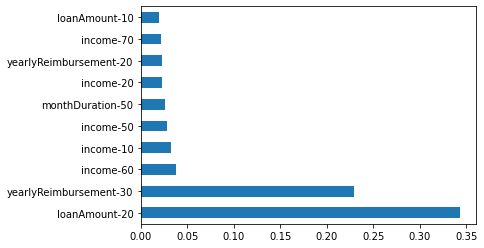

Wall time: 327 ms


In [14]:
%%time

Y = data["approval"]

X_train, X_test, y_train, y_test = train_test_split(booleanDF, Y, test_size=0.33, random_state=42)

#You should not run it as it takes too much time.
model = tree.ExtraTreeClassifier()
model.fit(X_train, y_train)

#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=booleanDF.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

# 3° Mix the thresholds

In [108]:
def andSeries(args):
    res = args[0]
    for i in range(1, len(args)):
        res = res & args[i]
    return res

In [114]:
%%time

for m in mix:
    tp = []
    for f in m:
        tp.append([])
        for p in thresholds_str:
            tp[-1].append(f+p)
    for i in range(len(thresholds_str)**len(tp)):
        res = ""
        arrays = []
        for j in range(len(tp)):
            res += tp[j][int(i/(len(thresholds_str)**(len(tp)-(1+j))))%len(thresholds_str)]+"&"
            arrays.append(booleanDF[tp[j][int(i/(len(thresholds_str)**(len(tp)-(1+j))))%len(thresholds_str)]])
        booleanDF[res[:-1]] = andSeries(arrays)

In [115]:
booleanDF

,creditScore-10,creditScore-20,creditScore-30,creditScore-40,creditScore-50,creditScore-60,creditScore-70,creditScore-80,creditScore-90,income-10,...,rate-80&yearlyReimbursement-90,rate-90&yearlyReimbursement-10,rate-90&yearlyReimbursement-20,rate-90&yearlyReimbursement-30,rate-90&yearlyReimbursement-40,rate-90&yearlyReimbursement-50,rate-90&yearlyReimbursement-60,rate-90&yearlyReimbursement-70,rate-90&yearlyReimbursement-80,rate-90&yearlyReimbursement-90
0,True,True,True,True,True,True,True,False,False,True,...,False,False,False,False,False,False,False,False,False,False
1,True,True,True,True,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
2,True,True,False,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
3,True,True,True,True,True,True,True,True,False,True,...,False,False,False,False,False,False,False,False,False,False
4,True,True,True,True,True,True,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,True,False,False,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
99996,True,False,False,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
99997,True,True,True,True,True,True,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
99998,True,True,False,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False


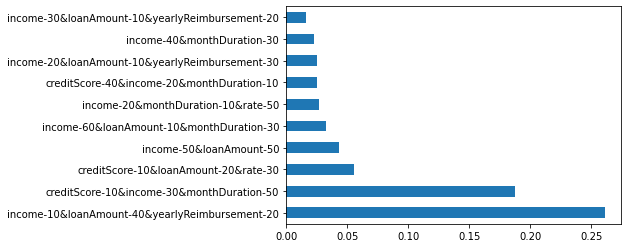

Wall time: 10.6 s


In [117]:
%%time

Y = data["approval"]

X_train, X_test, y_train, y_test = train_test_split(booleanDF, Y, test_size=0.33, random_state=42)

#You should not run it as it takes too much time.
model = tree.ExtraTreeClassifier()
model.fit(X_train, y_train)

#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=booleanDF.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

# 4° Save the best data

In [131]:
def intToStrIDS(idsInt):
    res = chr(97+idsInt%26)
    idsReducted = int(idsInt/26)
    while idsReducted != 0:
        res = chr(97+(idsReducted-1)%26) + res
        idsReducted = int(idsReducted/26)
    return res

def syntax(subject, predicate, objectD):
    return f"{subject}\t{predicate}\t{objectD} \n"#f"{intToStrIDS(subject)}\t{predicate}\t{objectD} \n"

def formatData(f, idData, data):
    toWrite = ""
    for i in data.index[1:]:
        toWrite += syntax(idData, i, data.loc[i])
    f.write(toWrite)

## -> The raw data

In [132]:
raw_data_set = set()
for combined_data in feat_importances.nlargest(50).index:
    for raw_data in combined_data.split("&"):
        raw_data_set.add(raw_data)

In [133]:
f = open("Knowledge Data - Raw data.tsv", "w")

booleanDF_reduced = booleanDF[raw_data_set]
booleanDF_reduced["approval"] = data["approval"].map({'true': True, 'false': False})

for idData in booleanDF_reduced.index:
    formatData(f, idData, booleanDF_reduced.iloc[idData])
    
f.close()

<ipython-input-133-0158df83b568>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  booleanDF_reduced["approval"] = data["approval"].map({'true': True, 'false': False})


## -> The combined data

In [134]:
f = open("Knowledge Data - Combined data.tsv", "w")

booleanDF_reduced = booleanDF[set(feat_importances.nlargest(50).index)]
booleanDF_reduced["approval"] = data["approval"].map({'true': True, 'false': False})

for idData in booleanDF_reduced.index:
    formatData(f, idData, booleanDF_reduced.iloc[idData])
    
f.close()

<ipython-input-134-05ff8bab21d8>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  booleanDF_reduced["approval"] = data["approval"].map({'true': True, 'false': False})


# Other stuff

In [33]:
feat_importances.nlargest(10).index

Index(['loanAmount-25&yearlyReimbursement-25',
       'loanAmount-50&monthDuration-25&yearlyReimbursement-25',
       'income-75&monthDuration-25', 'income-25&monthDuration-25',
       'income-25&yearlyReimbursement-25', 'yearlyReimbursement',
       'creditScore-25&income-25', 'loanAmount', 'income', 'monthDuration'],
      dtype='object')

In [31]:
feat_importances.nlargest(10).index

Index(['|creditScore-25|income-25|', '|creditScore-25|yearlyReimbursement-25|',
       '|loanAmount-50|yearlyReimbursement-25|',
       '|income-75|loanAmount-50|monthDuration-25|',
       '|income-50|monthDuration-50|', '|income-75|rate-25|',
       '|income-25|monthDuration-25|',
       '|income-50|rate-50|yearlyReimbursement-50|',
       '|income-75|loanAmount-25|monthDuration-25|',
       '|income-75|loanAmount-25|yearlyReimbursement-50|'],
      dtype='object')

In [21]:
print(model.score(X_train, y_train))
print(model.score(X_test, y_test))

0.9568358208955224
0.9554242424242424


In [35]:
for i in range(1,11):
    print(i)
    features = feat_importances.nlargest(i).index

    model.fit(X_train[features], y_train)

    print("\t",model.score(X_train[features], y_train))
    print("\t",model.score(X_test[features], y_test))
    
print("MAX")
model.fit(X_train, y_train)
print("\t",model.score(X_train, y_train))
print("\t",model.score(X_test, y_test))

1
	 0.7800597014925373
	 0.7812727272727272
2
	 0.8908059701492538
	 0.8889090909090909
3
	 0.8908059701492538
	 0.8889090909090909
4
	 0.8908059701492538
	 0.8889090909090909
5
	 0.9210298507462686
	 0.9192424242424242
6
	 0.924
	 0.9213636363636364
7
	 0.9265373134328359
	 0.9236363636363636
8
	 0.9276119402985075
	 0.925939393939394
9
	 0.9307313432835821
	 0.9283030303030303
10
	 0.9323731343283582
	 0.9297575757575758
MAX
	 0.9568358208955224
	 0.9554242424242424


In [13]:
def intToStrIDS(idsInt):
    res = chr(97+idsInt%26)
    idsReducted = int(idsInt/26)
    while idsReducted != 0:
        res = chr(97+(idsReducted-1)%26) + res
        idsReducted = int(idsReducted/26)
    return res

In [14]:
def ratios(idData, values):
    toReturn = ""
    YR = int(values[7]) if int(values[7]) > 0 else 0.1
    toReturn += syntax(idData, "ratioYI-YR", int((int(values[2])*12)/ YR))
    return toReturn

def GTE(idData, value, valuesToCompareTO, predicate):
    toReturn = ""
    for i in valuesToCompareTO:
        toReturn += syntax(idData, predicate+str(i), value>=i)
    return toReturn 

def LTE(idData, value, valuesToCompareTO, predicate):
    toReturn = ""
    for i in valuesToCompareTO:
        toReturn += syntax(idData, predicate+str(i), value<=i)
    return toReturn 

In [15]:
def syntax(subject, predicate, objectD):
    return f"{intToStrIDS(subject)}\t{predicate}\t{objectD} \n"#f"<{intToStrIDS(subject)}>\t<{predicate}>\t<{objectD}> \n"

 #syntax(idData, "name", data.values[0])\
def formatData(f, idData, data, dataDescribe):
    toWrite = ""\
             +syntax(idData, "creditScore", data.values[1])\
             +syntax(idData, "income", data.values[2])\
             +syntax(idData, "loanAmount", data.values[3])\
             +syntax(idData, "monthDuration", data.values[4])\
             +syntax(idData, "rate", data.values[5])\
             +syntax(idData, "approval", data.values[6])\
             +syntax(idData, "yearlyReimbursement", data.values[7])\
             +ratios(idData, data.values)\
             +GTE(idData, data.values[1], dataDescribe["creditScore"].iloc[4:].values, "CreditScoreGTE")\
             +LTE(idData, data.values[3], dataDescribe["loanAmount"].iloc[4:].values, "LoanLTE")
    f.write(toWrite)

In [16]:
f = open("Knowledge Data.tsv", "w")

dataDescribe = data.describe()
for idData in data.index:
    formatData(f, idData, data.iloc[idData], dataDescribe)
    break
    
f.close()

In [38]:
X = data.drop(columns=["approval"])
Y = data["approval"]

In [39]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

X["name"] = le.fit_transform(X["name"])

Y = Y.map({' false': False, ' true': True})

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X["creditScore"], Y, test_size=0.33, random_state=42)

In [55]:
%%time

#You should not run it as it takes too much time.
model = tree.ExtraTreeClassifier()
model.fit(np.array(X_train).reshape(-1,1), y_train)

# print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
# #plot graph of feature importances for better visualization
# feat_importances = pd.Series(model.feature_importances_, index=X.columns)
# feat_importances.nlargest(10).plot(kind='barh')
# plt.show()

Wall time: 19 ms


ExtraTreeClassifier()

[Text(2281.3742438477275, 5317.826086956522, 'X[0] <= 549.667\ngini = 0.343\nsamples = 67000\nvalue = [52264, 14736]'),
 Text(1424.0397581186073, 5081.478260869565, 'X[0] <= 492.655\ngini = 0.343\nsamples = 30210\nvalue = [23568, 6642]'),
 Text(758.8153610754011, 4845.130434782609, 'X[0] <= 325.263\ngini = 0.344\nsamples = 23280\nvalue = [18139, 5141]'),
 Text(173.41009446090214, 4608.782608695652, 'X[0] <= 310.715\ngini = 0.336\nsamples = 3169\nvalue = [2493, 676]'),
 Text(109.78480800402437, 4372.434782608696, 'X[0] <= 308.779\ngini = 0.341\nsamples = 1332\nvalue = [1041, 291]'),
 Text(79.84349673019955, 4136.086956521739, 'X[0] <= 306.689\ngini = 0.345\nsamples = 1094\nvalue = [852, 242]'),
 Text(49.90218545637472, 3899.7391304347825, 'X[0] <= 303.476\ngini = 0.34\nsamples = 858\nvalue = [672, 186]'),
 Text(19.960874182549887, 3663.391304347826, 'X[0] <= 300.742\ngini = 0.354\nsamples = 469\nvalue = [361, 108]'),
 Text(9.980437091274943, 3427.0434782608695, 'gini = 0.403\nsamples = 

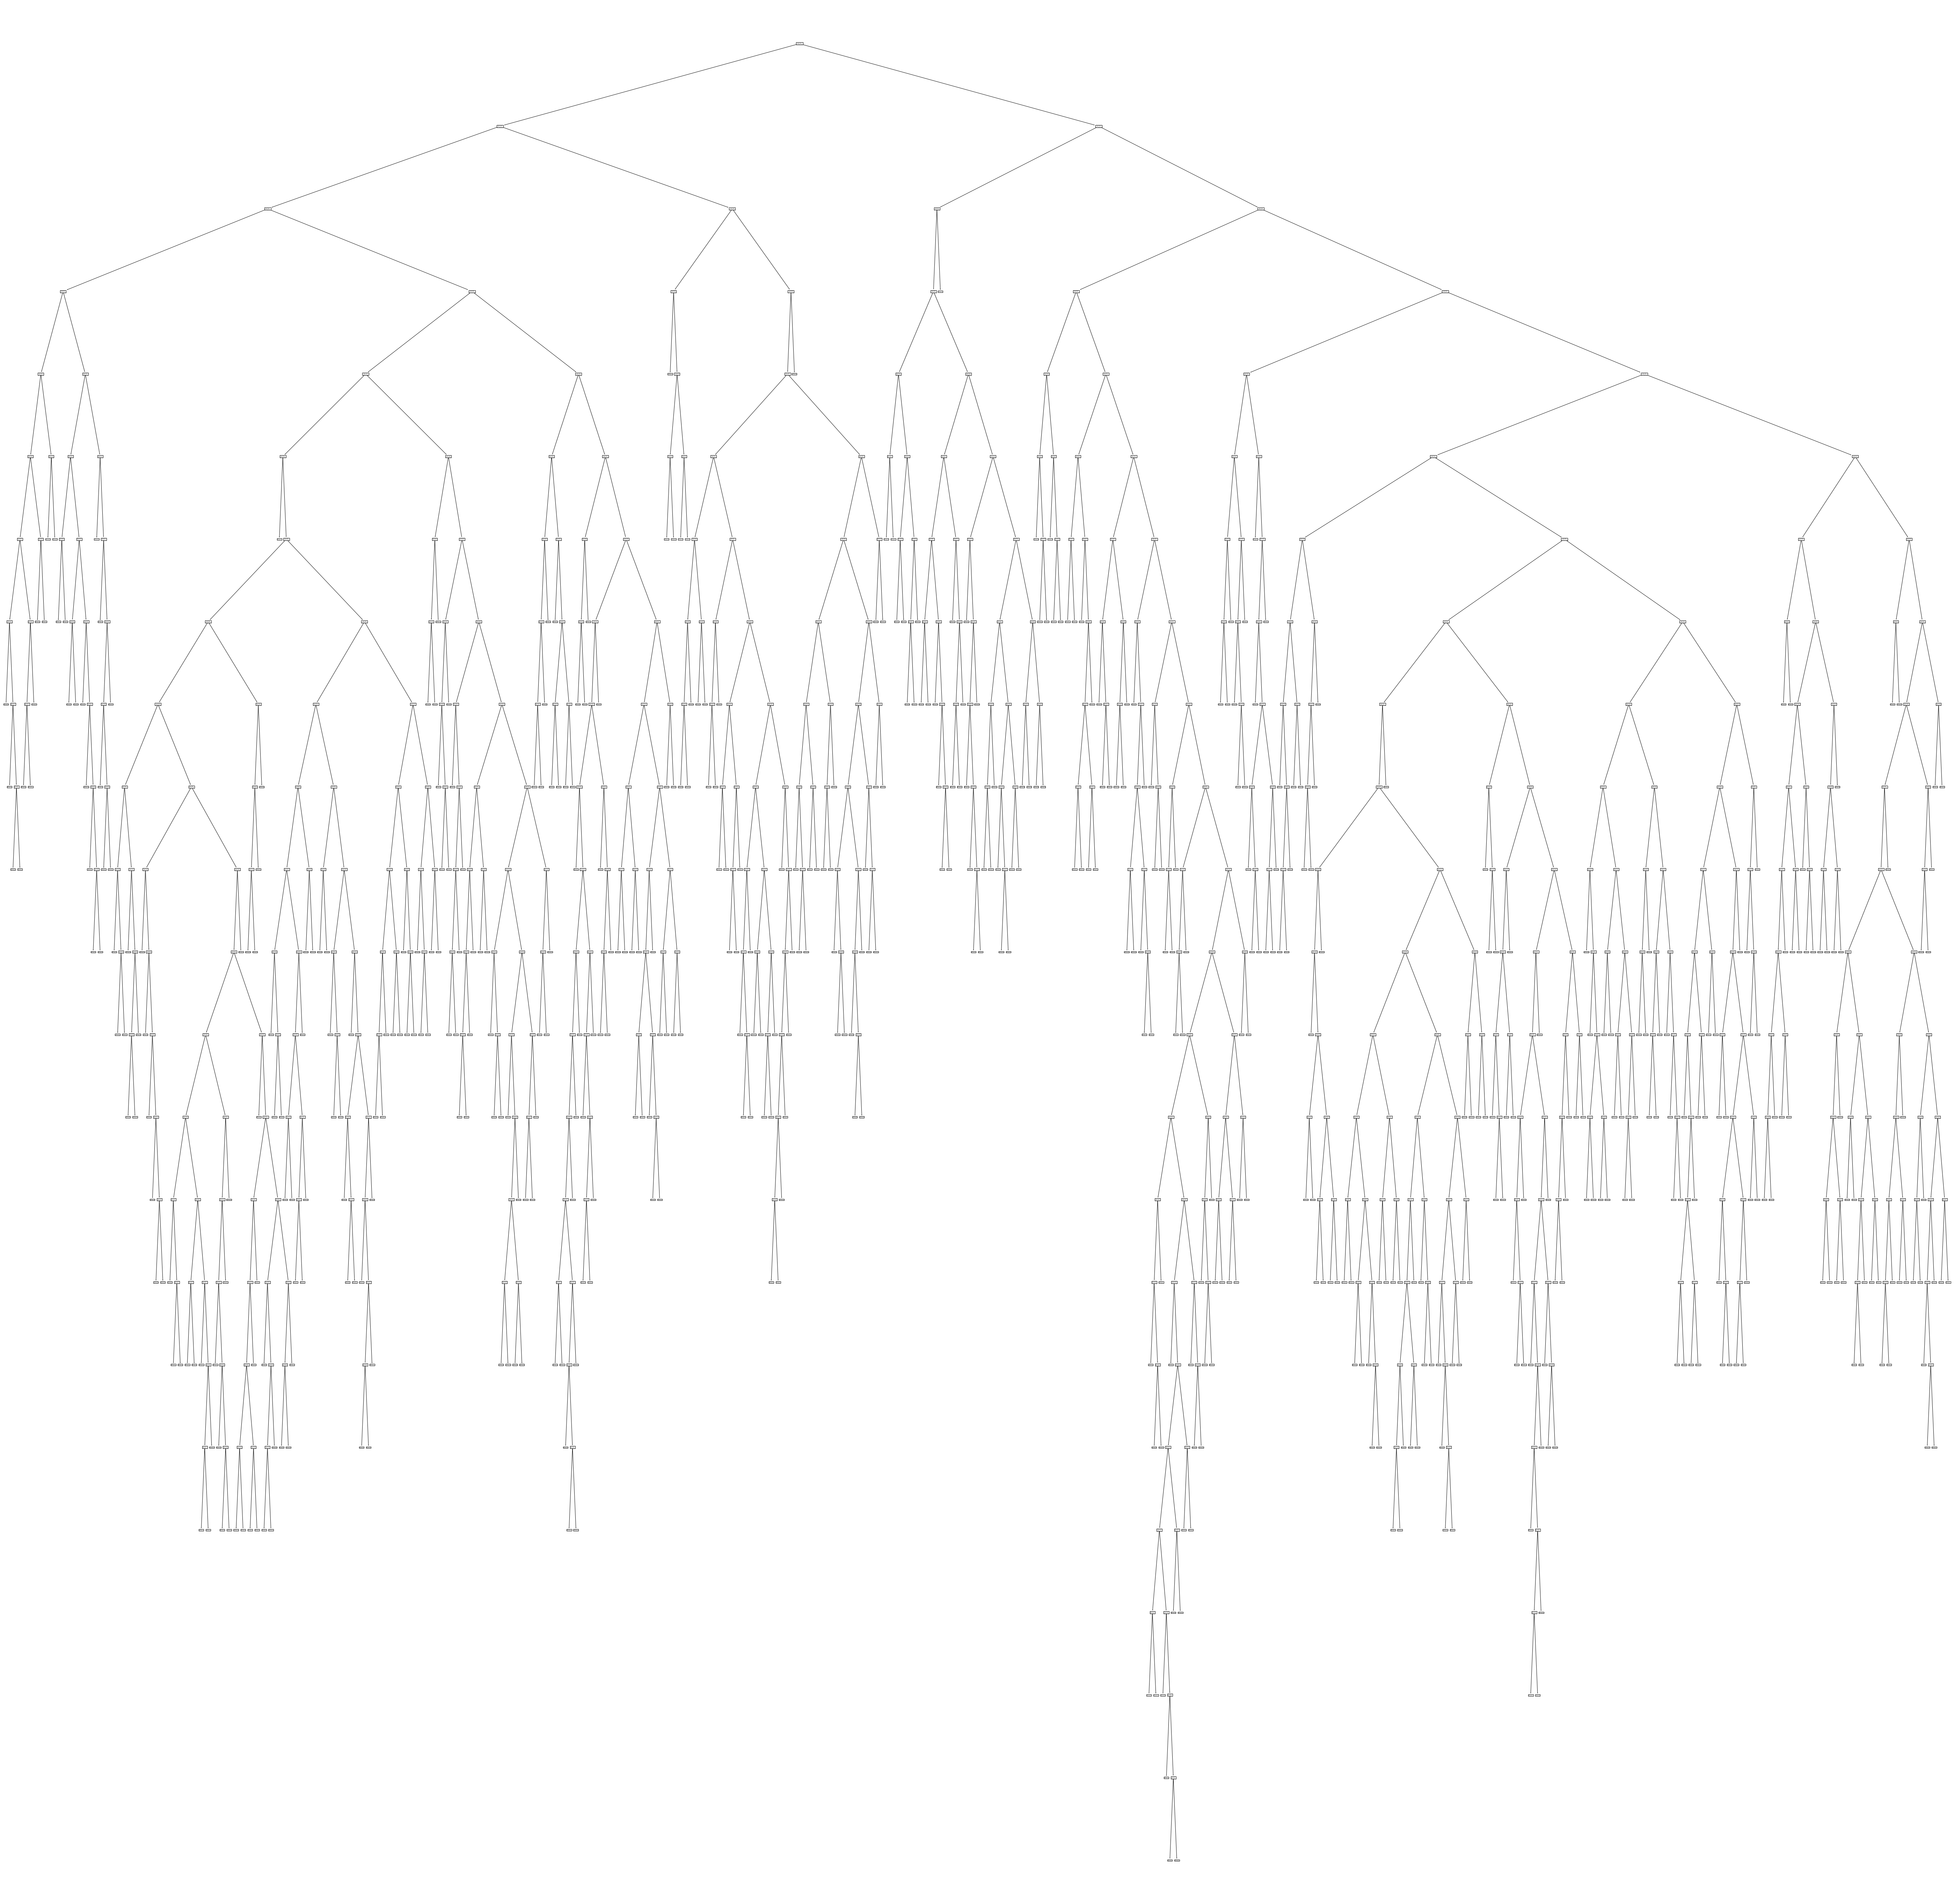

In [60]:
from sklearn import tree

fig, _axs = plt.subplots(nrows=1, ncols=1, figsize=(100,100))

tree.plot_tree(model)